In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import os
from math import * 
os.getcwd()
print("The current directory is: ")
print(os.getcwd())
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
print("Moving up to the parent directory")
print(os.getcwd())

The current directory is: 
\\home.org.aalto.fi\zopev1\data\Desktop\Abaqus-Macromechanics-Project
Moving up to the parent directory
\\home.org.aalto.fi\zopev1\data\Desktop


In [7]:
from stage0_configs import *
from modules.helper import *
info = main_config()

FileNotFoundError: [Errno 2] No such file or directory: 'configs/global_config.xlsx'

In [9]:
resultPath = info['resultPath']
targetPath = info['targetPath']
# Load csv file
target = pd.read_csv(f"{targetPath}/NDBR50/FD_Curve.csv")
expForce = target['force/N'].to_numpy()
expDisplacement = target['displacement/mm'].to_numpy() 
#print(max(expDisplacement))
targetCurve = {}
targetCurve['displacement'] = expDisplacement
targetCurve['force'] = expForce

initial_original_FD_Curves = np.load(f"{resultPath}/initial/common/FD_Curves.npy", allow_pickle=True).tolist()
initial_interpolated_FD_Curves = interpolating_FD_Curves(initial_original_FD_Curves, targetCurve)
print(list(initial_interpolated_FD_Curves.values())[0]['displacement'])


# print(maxDisp)
# Plotting all FD curves
figure(figsize=(8, 6), dpi=80)
plt.plot(expDisplacement, expForce, label='Experiment')
for param in initial_interpolated_FD_Curves:
    plt.plot(initial_interpolated_FD_Curves[param]['displacement'], initial_interpolated_FD_Curves[param]['force'], color='orange', alpha=0.5,
             #label=param
             )
plt.plot([],[], color='orange', alpha=0.5, label='Initial guesses')
plt.title('Exp and Interpolated Sim Force-Displacement Curves')
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (N)')
plt.legend()

# print(maxDisp)
# Plotting all FD curves
figure(figsize=(8, 6), dpi=80)
plt.plot(expDisplacement, expForce, label='Experiment')
for param in initial_original_FD_Curves:
    plt.plot(initial_original_FD_Curves[param]['displacement'], initial_original_FD_Curves[param]['force'], color='orange', alpha=0.5,
             #label=param
             )
plt.plot([],[], color='orange', alpha=0.5, label='Initial guesses')
plt.title('Exp and Original Sim Force-Displacement Curves')
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (N)')
plt.legend()



FileNotFoundError: [Errno 2] No such file or directory: 'MOO_targets/DP1000_400C_SwiftVoce_curve1/NDBR50/FD_Curve.csv'

### In total we have 20 initial guesses

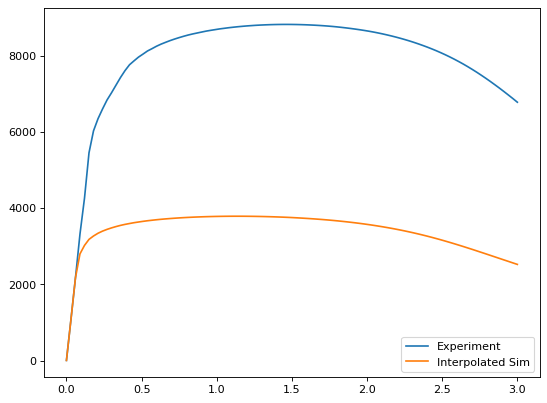

In [ ]:
# This is how you call the loss function
# They are in N, not kN
targetForce = targetCurve['force']
targetDisplacement = targetCurve['displacement']
# Datapoint at index i (0 to 19)
i = 0
interpolated_simForce = list(initial_interpolated_FD_Curves.values())[i]['force']

# Plotting the FD curve
figure(figsize=(8, 6), dpi=80)
plt.plot(targetDisplacement, targetForce, label='Experiment')
plt.plot(targetDisplacement, interpolated_simForce, label='Interpolated Sim')
plt.legend()

In [ ]:
# Define your loss function. 
# We assume targetForce and simForce are both numpy arrays
# We also assume the force share the same strain points (simForce has been interpolated onto target strain points)
# In our case, both targetForce and simForce are in unit N, not kN
# The loss function should return a single scalar number
# The smaller the number, the better the fit

def lossFD(targetForce, simForce):
    return np.sqrt(np.mean((targetForce - simForce)**2))

In [ ]:
def loss_plastic(targetDisplacement, targetForce, simForce, step, epsilon=1e-8):
    """
    This function calculates the loss for the plastic region of the force-displacement curve. 
    The loss is a weighted sum of the residuals loss, slope loss, and important points penalty.
    The weights adapt as the number of steps increases.
    """

    # Calculate residuals and corresponding loss
    residuals = targetForce - simForce
    residuals_loss = np.sqrt(np.mean(residuals ** 2))

    # Calculate slopes and corresponding loss
    slope_true = np.diff(targetForce) / np.diff(targetDisplacement)
    slope_pred = np.diff(simForce) / np.diff(targetDisplacement)
    slope_loss = np.sqrt(np.mean((slope_true - slope_pred) ** 2))

    # Calculate first element penalty
    first_true = targetForce[0]
    first_pred = simForce[0]
    first_penalty = abs(first_true - first_pred)

    # Calculate peak penalty
    peak_true = np.argmax(targetForce)
    peak_pred = np.argmax(simForce)
    peak_penalty = abs(targetForce[peak_true] - simForce[peak_pred])

    # Calculate last element penalty
    last_true = targetForce[-1]
    last_pred = simForce[-1]
    last_penalty = abs(last_true - last_pred)

    # Calculate maximum loss values for normalization and add epsilon to prevent division by zero
    max_residuals_loss = np.max(np.sqrt(np.mean((targetForce - targetForce.mean()) ** 2))) + epsilon
    max_slope_loss = np.max(np.sqrt(np.mean((np.diff(targetForce) / np.diff(targetDisplacement)) ** 2))) + epsilon
    max_first_penalty = np.max(abs(targetForce[0] - targetForce.mean())) + epsilon
    max_peak_penalty = np.max(abs(targetForce[np.argmax(targetForce)] - targetForce.mean())) + epsilon
    max_last_penalty = np.max(abs(targetForce[-1] - targetForce.mean())) + epsilon

    # Set fixed weights for residuals and slope loss
    w_res = 2
    w_slope = 1

    # Calculate adaptive weights for penalties
    # These weights start low and increase with each step
    w_first = step * 0.001
    w_peak = step * 0.001
    w_last = step * 0.001

    # Normalized and weighted loss calculation
    loss = (w_res * residuals_loss / max_residuals_loss +
            w_slope * slope_loss / max_slope_loss +
            w_first * first_penalty / max_first_penalty +
            w_peak * peak_penalty / max_peak_penalty +
            w_last * last_penalty / max_last_penalty)

    return loss


def lossFD(targetDisplacement, targetForce, simForce,iteration):
    return loss_plastic(targetDisplacement, targetForce, simForce, iteration)
    

In [ ]:
# For each interpolated simulation curve, calculate the loss and plot the sim curve against target curve

for i in range(len(initial_interpolated_FD_Curves)):
    interpolated_simForce = list(initial_interpolated_FD_Curves.values())[i]['force']

    # Plotting the FD curve
    figure(figsize=(8, 6), dpi=80)
    plt.plot(targetDisplacement, targetForce, label='Experiment')
    plt.plot(targetDisplacement, interpolated_simForce, label='Interpolated Sim')
    plt.legend()
    plt.show()
    print(custom_loss_func(targetDisplacement,targetForce, interpolated_simForce))
    print(lossFD(targetForce, interpolated_simForce))



NameError: name 'initial_interpolated_FD_Curves' is not defined